In [33]:
import nest
import h5py
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import warnings
warnings.filterwarnings('ignore')

In [34]:
def chen_to_bmtk_mapping_dict(chen_network_path='Allen_V1_param/network_dat.pkl', 
                              bmtk_nodes_path='Allen_V1_param/network/v1_nodes.h5'):
    
    """ 给出chen 111个神经元模板和bmtk 111给神经元模板之间的对应关系 """

    chen_to_bmtk_mapping = {}

    with h5py.File(bmtk_nodes_path, 'r') as f:
        node_type_ids = f['nodes']['v1']['node_type_id'][:]
    with open(chen_network_path, 'rb') as f:
        chen_data = pkl.load(f)

    for chen_neuron_model_template_index in range(111):
        unique_set = list(set(node_type_ids[chen_data['nodes'][chen_neuron_model_template_index]['ids']]))
        # 验证集合元素数量
        if len(unique_set) == 0:
            raise ValueError("未找到bmtk神经元模板")
        elif len(unique_set) == 1:
            chen_to_bmtk_mapping[chen_neuron_model_template_index] = unique_set[0]
        else:
            raise ValueError(f"出现多个bmtk神经元模板与之对应")
            
    return chen_to_bmtk_mapping

In [35]:
def simulate_neuron_response(node_type_id, platform_current,
                             T=1000, dt=0.1, current_start=200, current_end=800):
    node_types = pd.read_csv('Allen_V1_param/network/v1_node_types.csv')
    h5_nodes = h5py.File('Allen_V1_param/network/v1_nodes.h5', 'r')
    model_template = 'glif_psc'
    dynamics_path = f'Allen_V1_param/components/cell_models/nest_models/'+str(node_type_id)+'_glif_psc.json'
    with open(dynamics_path, 'r') as f:
        dynamics_params = json.load(f)
        
    # 创建NEST模型
    nest.ResetKernel()
    nest.SetKernelStatus({'resolution': dt})  # 0.1 ms 时间分辨率

    # 注册模型
    neuron = nest.Create(model_template, 1, params=dynamics_params)
    
    # Step 3: 添加multimeter记录膜电位
    mm = nest.Create("multimeter", params={
        "interval": dt,
        "record_from": ["V_m"]
    })
    nest.Connect(mm, neuron)
    
    # Step 4: 注入平台电流
    current_sequence = np.zeros(9990, dtype=np.float32)
    current_sequence[current_start*10:current_end*10] = platform_current
    stim = nest.Create("dc_generator", params={
        "amplitude": platform_current,  # 单位: pA
        "start": current_start,      # ms
        "stop": current_end       # ms
    })
    nest.Connect(stim, neuron)

    # Step 5: 仿真并记录
    nest.Simulate(T)
    data = nest.GetStatus(mm)[0]["events"]
    time = data["times"]
    voltages = data["V_m"]
    
    spikes = np.zeros(voltages.shape)
    spikes[np.where(np.gradient(voltages)<-5)[0][0::2]-1] = 1
    
    return time, current_sequence, voltages, spikes

In [36]:
def plot_single_response(time, current, voltage, spikes, neuron_type, current_amplitude):
    """
    绘制单个神经元的响应图
    
    参数:
    - time: 时间序列
    - current: 输入电流序列
    - voltage: 膜电位序列
    - spikes: 脉冲序列
    - neuron_type: 神经元类型
    - current_amplitude: 电流幅度
    - save_path: 保存路径 (可选)
    - show_plot: 是否显示图像
    """
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,4), sharex=True)
    
    # 上方子图：输入电流
    ax1.plot(time, current, 'b-', linewidth=2, label=f'Input current ({current_amplitude} pA)')
    ax1.set_ylabel('Current (pA)', fontsize=12)
    ax1.set_title(f'{neuron_type} neuron response - current: {current_amplitude} pA', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # 下方子图：膜电位和脉冲
    ax2.plot(time, voltage, 'k-', linewidth=1.5, label='V_m')
    
    # 添加脉冲标记（在对应时间点的膜电位上画红色竖线）
    spike_indices = np.where(spikes > 0.5)[0]  # 找到脉冲发生的时间点索引
    for spike_idx in spike_indices:
        spike_voltage = voltage[spike_idx]  # 获取脉冲时刻的膜电位值
        ax2.plot(time[spike_idx], spike_voltage, '|k', markersize=10, color='red')
    
    ax2.set_xlabel('Time (ms)', fontsize=12)
    ax2.set_ylabel('V_m (mV)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # 添加脉冲计数信息
    spike_count = np.sum(spikes > 0.5)
    firing_rate = spike_count / (time[-1] / 1000)  # Hz
    ax2.text(0.02, 0.98, f'Spike number: {spike_count}\n firing rate: {firing_rate:.2f} Hz', 
             transform=ax2.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return fig

def analyze_current_response(node_type_id, current_amplitudes,
                             T=1000, dt=0.1, current_start=200, current_end=800):
    """
    分析神经元在不同电流强度下的响应
    
    参数:
    - neuron_type: 神经元类型
    - current_amplitudes: 电流强度列表
    - model_path: 模型文件路径
    - show_plot: 是否显示图像
    """
    
    # 创建多子图
    n_currents = len(current_amplitudes)
    fig, axes = plt.subplots(n_currents + 1, 1, figsize=(10, 2 * (n_currents + 1)), 
                            gridspec_kw={'hspace': 0.3})
    
    # 颜色映射
    colors = plt.cm.viridis(np.linspace(0, 1, n_currents))
    
    # 第一个子图：显示所有电流波形
    time_ref = np.arange(9990)  # 参考时间序列
    for i, current_amp in enumerate(current_amplitudes):
        current_waveform = np.zeros(9990)
        current_waveform[2000:8000] = current_amp
        axes[0].plot(time_ref, current_waveform, color=colors[i], linewidth=2, 
                    label=f'{current_amp} pA')
    
    axes[0].set_ylabel('Current (pA)', fontsize=12)
    axes[0].set_title(f'{node_type_id} neuron response', fontsize=14)
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 存储结果用于分析
    all_results = []
    
    # 对每个电流强度进行仿真
    for i, current_amp in enumerate(current_amplitudes):
        print(f"\n处理电流强度: {current_amp} pA ({i+1}/{n_currents})")
        
        # 运行仿真
        time, current, voltage, spikes = simulate_neuron_response(node_type_id, current_amp)
        
        # 存储结果
        spike_count = np.sum(spikes > 0.5)
        firing_rate = spike_count / (time[-1] / 1000)
        all_results.append({
            'current': current_amp,
            'spike_count': spike_count,
            'firing_rate': firing_rate,
            'voltage': voltage,
            'spikes': spikes
        })
        
        # 绘制到对应子图
        ax = axes[i + 1]
        ax.plot(time, voltage, color='black', linewidth=1.5, label='V_m')
        
        # 添加脉冲标记（在对应时间点的膜电位上画红色竖线）
        spike_indices = np.where(spikes > 0.5)[0]
        for spike_idx in spike_indices:
            spike_voltage = voltage[spike_idx]  # 获取脉冲时刻的膜电位值
            ax.plot(time[spike_idx], spike_voltage, '|k', markersize=10, color='red')
        
        ax.set_ylabel('V_m (mV)', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.text(0.02, 0.98, f'{current_amp} nA\n spike: {spike_count}\n rate: {firing_rate:.1f} Hz', 
                transform=ax.transAxes, verticalalignment='top', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    axes[-1].set_xlabel('时间 (ms)', fontsize=12)
    plt.tight_layout(pad=0.5)
    plt.show()
    
    # 绘制I-F曲线
    plot_if_curve(node_type_id, all_results)
    
    return all_results

def plot_if_curve(neuron_type, results):
    """
    绘制电流-发放频率(I-F)曲线
    
    参数:
    - neuron_type: 神经元类型
    - results: 仿真结果列表
    """
    
    currents = [r['current'] for r in results]
    firing_rates = [r['firing_rate'] for r in results]
    
    plt.figure(figsize=(5,3))
    plt.plot(currents, firing_rates, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('input current (nA)', fontsize=12)
    plt.ylabel('firing rate (Hz)', fontsize=12)
    plt.title(f'{neuron_type} I-F curve', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # 添加数据标签
    for i, (curr, rate) in enumerate(zip(currents, firing_rates)):
        plt.annotate(f'{rate:.1f}', (curr, rate), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

In [37]:
chen_to_bmtk_mapping = chen_to_bmtk_mapping_dict()


Jul 08 15:10:21 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 08 15:10:21 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 08 15:10:21 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 08 15:10:21 SimulationManager::run [Info]: 
    Simulation finished.


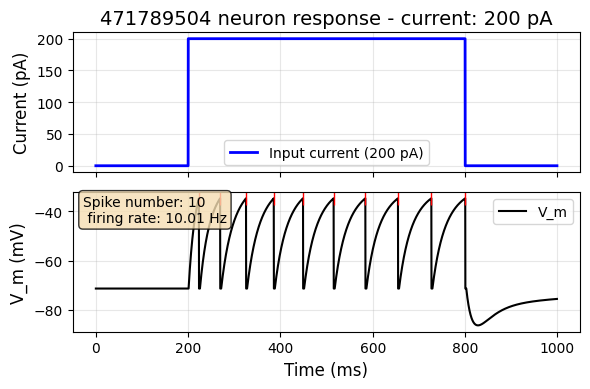

In [38]:
chen_neuron_model_template_index = 110
node_type_id = chen_to_bmtk_mapping[chen_neuron_model_template_index]
platform_current = 200
time, current, voltage, spikes = simulate_neuron_response(node_type_id=node_type_id, 
                                                          platform_current=platform_current)

fig = plot_single_response(
    time, current, voltage, spikes, 
    node_type_id, platform_current
)


处理电流强度: 0.0 pA (1/11)

Jul 08 15:10:22 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

处理电流强度: 30.0 pA (2/11)

Jul 08 15:10:22 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 08 15:10:22 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 08 15:10:22 SimulationManager::run [Info]: 
    Simulation finished.

Jul 08 15:10:22 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 08 15:10:22 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 08 15:10:22 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 08 15:10:22 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 40.0 pA (3/11)

Jul 08 15:10:22 SimulationManager::set_s

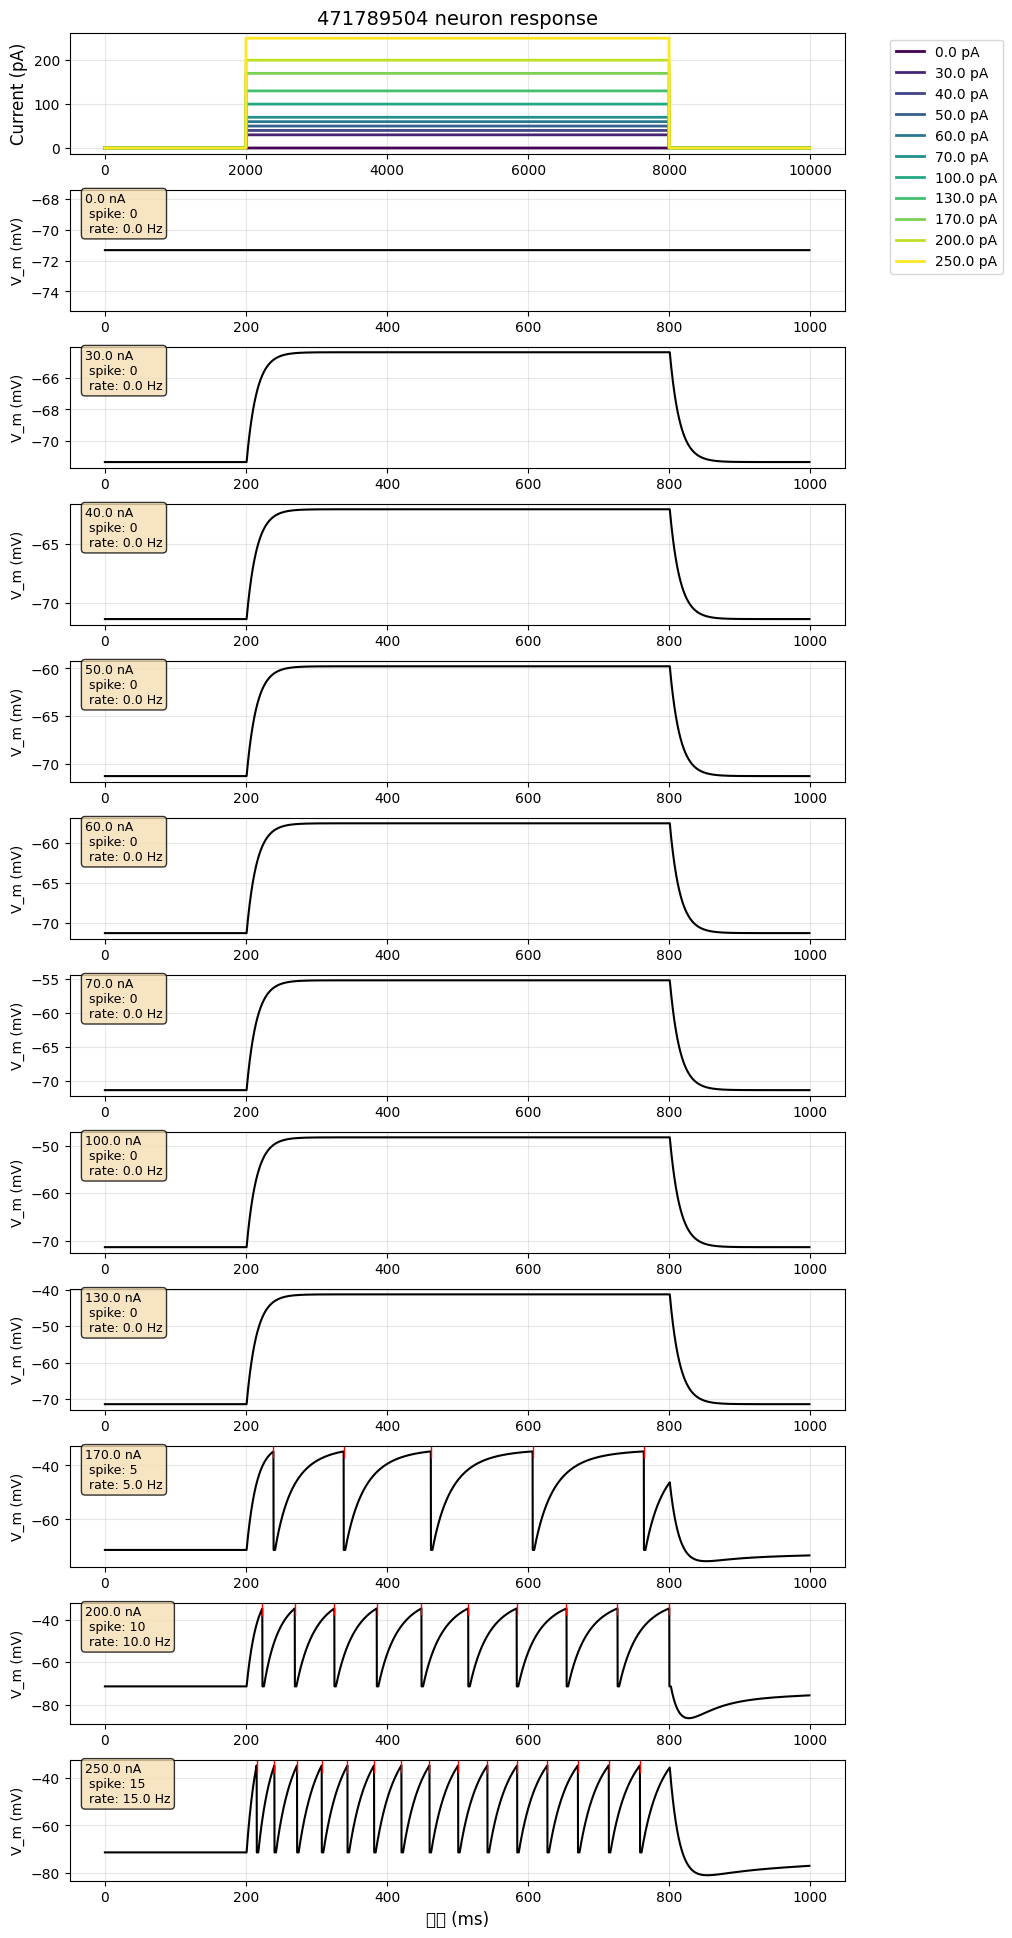

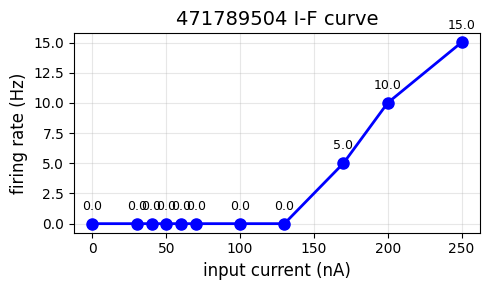

In [39]:
current_amplitudes = np.array([0, 0.03, 0.04, 0.05, 0.06, 0.07, 0.1, 0.13, 0.17, 0.2, 0.25])

# 运行分析
results = analyze_current_response(
    node_type_id=node_type_id,
    current_amplitudes=current_amplitudes * 1000
)